# Random Forest su dataset relativo ai livelli di ansia e di depressione.

Il nostro obbiettivo consiste nell'utilizzare la tecnica della random forest per misurare i livelli di ansia e di depressione delle persone.
Per raggiungere tale scopo, il nostro compito consiste nel:

- Costruire una random forest per predirre il livello d'ansia delle persone, sfruttando le variabili interne del dataset (escludendo il livello di depressione tra le variabili.
- Costruire una random forest per predirre il livello di depressione delle persone, usando tutte le variabili interne della struttura dati adoperata ad eccezione dell'ansia.
Queste due situazioni vengono esaminate in separata sede.

In [137]:
import itertools
import sys

import pandas as pd
import numpy as np
df = pd.read_excel("Data/S1%20File.xlsx")
#Rimozione colonne inutili e valori nulli
df.drop(columns=["Average weekday", "Average weekend day"], inplace=True)
df.dropna(inplace=True)

#Lista ordine delle colonne
columns_order = df.columns

#Cambio del valore in Genere 1:Maschio 0:Femmina
df["Gender"] = np.where(df["Gender"] == 2, 1,0)
gender = df["Gender"]
df.drop(columns=["ID No"], inplace=True)

#df = df[columns_order]
df.reset_index(drop=True, inplace=True)
df


,Age,Height (m),Weight (kgs),BMI,working hours per week,Gender,Total anxiety score,Total Depression score,RP,RE,...,Sitting only,Time standing (h),Time stepping (h),Step count,Sit to stand transitions,Sitting only.1,Time standing (h).1,Time stepping (h).1,Step count.1,Sit to stand transitions.1
0,36.0,1.55,57.0,23.725286,32.0,1,2.0,0.0,100.0,100.0,...,7.650000,4.2825,1.947500,10825.500000,64.000000,7.175,5.675,1.975,8256.0,85.5
1,37.0,1.71,76.0,25.990903,11.5,1,3.0,3.0,100.0,100.0,...,5.866667,6.7400,3.273333,13239.333333,82.333333,9.520,5.190,2.125,7959.0,75.0
2,36.0,1.68,64.0,22.675737,42.5,0,10.0,9.0,100.0,100.0,...,9.005000,5.6925,1.862500,9120.500000,36.000000,6.695,4.550,1.635,8707.0,32.5
3,40.0,1.55,59.0,24.557752,22.0,1,9.0,3.0,100.0,100.0,...,8.373333,3.7700,1.706667,8694.666667,75.333333,10.590,1.840,0.575,2401.0,40.5
4,29.0,1.56,79.0,32.462196,37.0,0,2.0,1.0,100.0,100.0,...,6.460000,2.5700,1.630000,8693.000000,42.500000,8.445,4.040,3.555,18977.0,65.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,23.0,178.00,88.8,28.000000,35.0,1,1.0,0.0,100.0,100.0,...,9.986000,2.3740,1.322000,7026.800000,31.500000,11.405,1.895,0.860,4412.0,33.0
61,32.0,160.50,83.1,32.300000,40.0,1,4.0,4.0,0.0,50.0,...,9.875000,3.0575,1.110000,5130.500000,39.250000,8.225,3.040,2.015,9374.0,34.5
62,44.0,161.50,70.5,25.200000,35.0,1,7.0,0.0,100.0,100.0,...,7.840000,2.3220,1.972000,11926.800000,52.000000,10.165,4.100,1.290,6351.0,53.5
63,45.0,184.00,91.9,27.100000,35.0,0,5.0,1.0,100.0,100.0,...,8.505000,3.1350,2.867500,17242.500000,46.000000,13.550,2.755,1.700,10245.0,51.5


In [138]:
import random
from random import sample
#random forest per livello depressione, senza ansia.
y_depression = df["Total Depression score"]
df_smaller = df.drop(columns=["Total anxiety score", "Total Depression score"], inplace = False)

seed = 2023
random.seed(seed)

test_idx_depression = sample(range(0,df_smaller.shape[0]),20)
test_depression = df_smaller.iloc[test_idx_depression]
df_training_validation = df_smaller.drop(df_smaller.index[test_idx_depression], inplace=False)

## Creazione della random forest su variabile di risposta livello di depressione

Al momento attuale sfruttiamo una k-fold cross validation con $k=5$ per cercare i vari iperparametri ottimali riguardanti:

- la profondità dell'albero (parametro che varia da 2 a 6)
- il numero di features utilizzate 
- il numero di alberi
Sfruttiamo la libreria sklearn per creare un RandomForestRegressor che, tramite il metodo fit, ci consente di calcolare il nostro modello. 

In [139]:
#crea la random forest per la depressione
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def standardized_dataset(dataset, indexes, gender_col):
        dataframe = dataset.drop(columns=["Gender"]).iloc[indexes]
        df_mean =dataframe.mean()
        df_std = dataframe.std()
        dataframe = (dataframe - df_mean)/df_std
        dataframe["Gender"] = gender_col
        return dataframe, df_mean, df_std
        

def standardized_dataset_mean_std(dataset, indexes, gender_col,df_mean,df_std):
        dataframe = dataset.drop(columns=["Gender"]).iloc[indexes]
        dataframe = (dataframe - df_mean)/df_std
        dataframe["Gender"] = gender_col
        return dataframe


def choose_hyperparams(dataframe,y,seed_p):
        max_depth = range(2,7)
        max_features = ["sqrt", "log2", 0.3]
        n_trees = [10,50,100]
        kf = KFold(n_splits=5 , shuffle=True, random_state=seed_p)
        kf.get_n_splits(dataframe)
        min_validation_error = sys.maxsize
        min_rf = None
        mse_val_ep = []
        mse_tr_ep = []
        rf = None
        for depth,features,estimators in itertools.product(max_depth,max_features,n_trees):
                mse_val_list = []
                mse_train_list = []
                for z, (train_index, validation_index) in enumerate(kf.split(dataframe)):
                        #standardizzazione dati di training
                        gender_t = dataframe["Gender"].iloc[train_index]
                        data_train,df_mean,df_std = standardized_dataset(dataframe, train_index, gender_t)
                        #standardizzazione dati validation
                        gender_v = dataframe["Gender"].iloc[validation_index]
                        data_validation = standardized_dataset_mean_std(dataframe, validation_index, gender_v, df_mean,df_std)
                        rf = RandomForestRegressor(max_depth=depth, random_state=seed_p, max_features=features, n_estimators=estimators)
                        rf.fit(data_train, y.iloc[train_index])
                        y_validation = rf.predict(data_validation)
                        y_training = rf.predict(data_train)
                        #calcolo training error
                        mse_tr= np.mean((y.iloc[train_index]-y_training)**2)
                        #Calcolo del validation error...
                        mse_val = np.mean((y.iloc[validation_index]-y_validation)**2)
                        mse_val_list.append(mse_val)
                        mse_train_list.append(mse_tr)
                    
                mse_validation = np.mean(mse_val_list)
                mse_train = np.mean(mse_train_list)
                mse_val_ep.append(mse_validation)
                mse_tr_ep.append(mse_train)
                if min_validation_error > mse_validation:
                        min_rf = rf
                        min_validation_error = mse_validation
        return min_rf, mse_tr_ep, mse_val_ep

In [140]:
min_model, mse_tr_epochs, mse_val_epochs = choose_hyperparams(df_training_validation,y_depression.iloc[df_training_validation.index],seed)
print(min_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


### Grafico di training e di validation

Dal grafico di training e di validation, vediamo che il training error diminuisce sempre di più con l'aumento delle epoche (questo è dovuto al fatto che infatti si cerca di minimizzare l'errore di training durante l'algoritmo). Il modello che scegliamo è quello che ci offre un validation error minimo. In teoria, l'andamento del validation error dovrebbe essere inizialmente decrescente fino a quando si avrà una inversione di tendenza (ovvero ad un certo punto il valore della loss function inizierà a salire). Nel nostro caso l'andamento del validation error non è sempre così, e questo potrebbe essere dovuto alla scarsa quantità dei dati su cui lavoriamo.

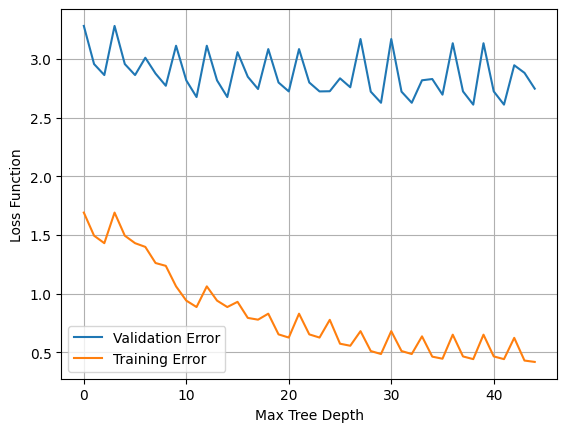

In [141]:
fig, ax = plt.subplots()        
ax.plot(range(0,45), mse_val_epochs, label="Validation Error")
ax.plot(range(0,45), mse_tr_epochs, label="Training Error")
ax.legend()
plt.xlabel("Max Tree Depth")
plt.ylabel("Loss Function")
plt.grid()
plt.show()


### Calcolo del MSE di test
Purtroppo, siccome i dati sono stati normalizzati precedentemente, vediamo che la random forest per predirre il livello di depressione ha un errore di test molto elevato.

In [142]:
#Fit the final model using training+validation set
print(df_training_validation)
df_training_validation, df_tr_val_mean, df_tr_val_std = standardized_dataset(df_training_validation,range(0,45), df_training_validation["Gender"])
min_model.fit(df_training_validation, y_depression.iloc[df_training_validation.index])
test_depression = standardized_dataset_mean_std(test_depression, range(0,20), test_depression["Gender"], df_tr_val_mean, df_tr_val_std)
y_depression_estimate = min_model.predict(test_depression)
MSE_ERROR = np.mean((y_depression_estimate-y_depression.iloc[test_idx_depression])**2)
print("MSE_ERROR =",MSE_ERROR)

     Age  Height (m)  Weight (kgs)        BMI  working hours per week  Gender  \
0   36.0       1.550          57.0  23.725286                   32.00       1   
1   37.0       1.710          76.0  25.990903                   11.50       1   
3   40.0       1.550          59.0  24.557752                   22.00       1   
4   29.0       1.560          79.0  32.462196                   37.00       0   
6   39.0       1.550          79.0  32.882414                   40.00       1   
8   35.0       1.680          64.0  22.675737                   40.00       1   
9   35.0       1.810          83.0  25.335002                   36.00       0   
12  52.0       1.630          62.0  23.335466                   28.00       1   
14  49.0       1.700          84.0  29.065744                   40.00       0   
15  42.0       1.780          63.0  19.883853                   40.00       0   
17  21.0       1.830          78.0  23.291230                    0.00       0   
18  49.0       1.750        

### Esempio di visualizzazione di albero

In seguito abbiamo visualizzato uno degli alberi creati durante l'algoritmo di random forest.

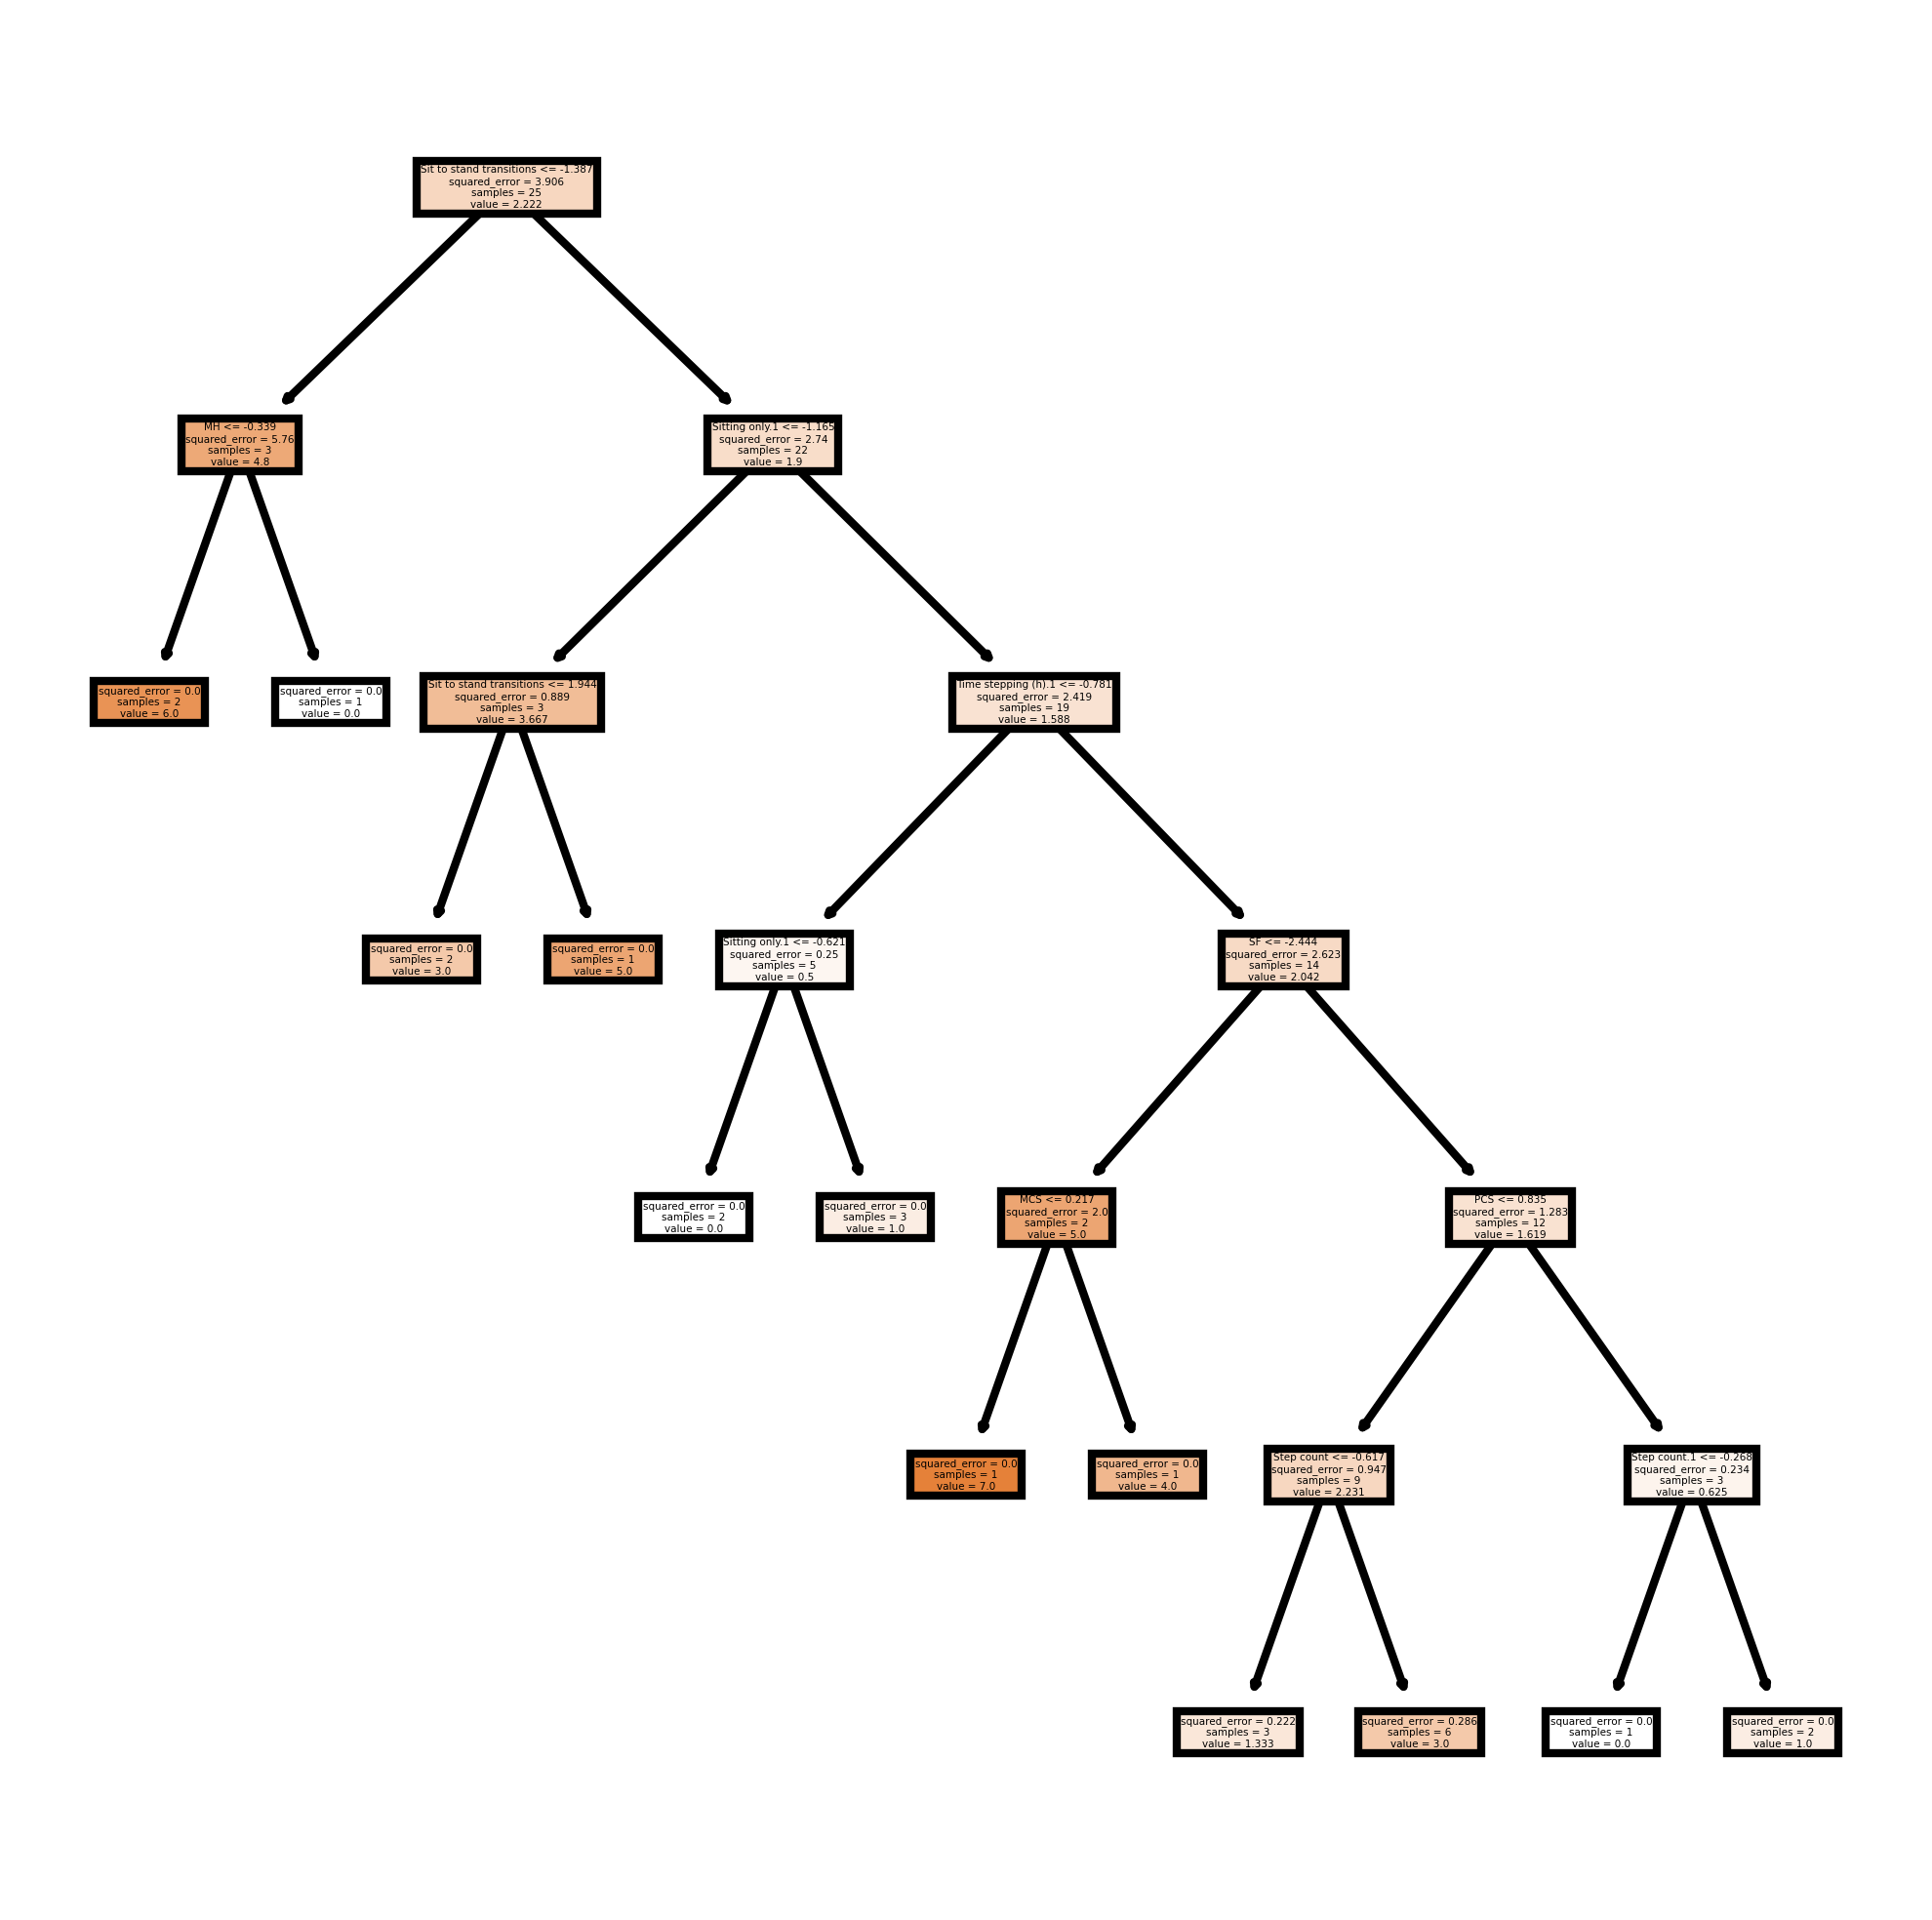

In [143]:
from sklearn import tree
figure, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(min_model.estimators_[0],
               filled = True,feature_names=df_smaller.columns)
figure.savefig('pictures/rf_individualtree.png')

## Calcolo dell'ansia


In [144]:
from sklearn.ensemble import RandomForestRegressor 
#random forest per livello depressione, senza ansia.
y_anxiety = df["Total anxiety score"]
df_anxiety = df.drop(columns=["Total anxiety score", "Total Depression score"], inplace = False)

min_model_anxiety, mse_tr_epochs_anxiety, mse_val_epochs_anxiety = choose_hyperparams(df_training_validation,y_anxiety.iloc[df_training_validation.index],seed)
print(min_model_anxiety.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 0.3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


### Calcolo Test Error


In [145]:
#Fit the final model using training+validation set
min_model_anxiety.fit(df_training_validation, y_anxiety.iloc[df_training_validation.index])
y_anxiety_estimate = min_model_anxiety.predict(test_depression)
MSE_ERROR_anxiety = np.mean((y_anxiety_estimate-y_anxiety.iloc[test_idx_depression])**2)
print("MSE_ERROR =",MSE_ERROR_anxiety)

MSE_ERROR = 7.258328042137033


### Grafico Loss function

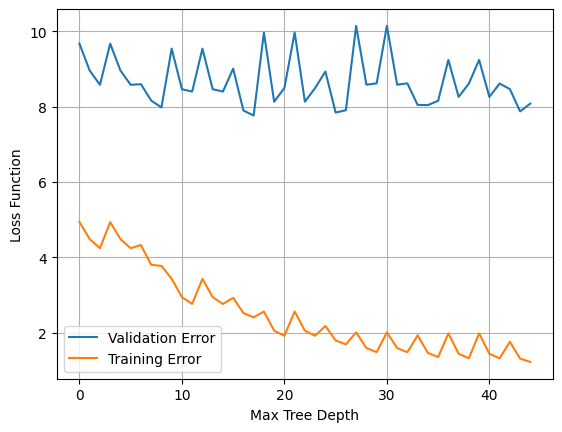

In [146]:
fig_anx, ax_anxiety = plt.subplots()        
ax_anxiety.plot(range(0,45), mse_val_epochs_anxiety, label="Validation Error")
ax_anxiety.plot(range(0,45), mse_tr_epochs_anxiety, label="Training Error")
ax_anxiety.legend()
plt.xlabel("Max Tree Depth")
plt.ylabel("Loss Function")
plt.grid()
plt.show()
